# Spreadsheet for advanced cannons #

Using data from https://fromthedepths.gamepedia.com/index.php?title=Advanced_Cannon&oldid=8383

In [1]:
from sympy import *
import math
from IPython.display import HTML, display
import ftd_calc as FTD
init_printing()

In [2]:
def formatValue(key, value):
    if key == 'diameter':
        return '{:3}'.format(math.floor(value*1000))
    if key == 'damage':
        damage_data = []
        for dtype, damage in value.items():
            if isinstance(damage, tuple) and len(damage) == 2:
                damage_data.append('{0}={1:3d}:{2:3.1f}'.format(dtype, int(damage[0]), damage[1]))
            else:
                damage_data.append('{0}={1}'.format(dtype, str(damage)))
        return '</br>'.join(damage_data)
    if isinstance(value, float):
        return '{: 3.2f}'.format(value)
    
    return str(value)

def displayTable(results, columns):
    # Row start - caption
    # Column - output variant
    # html = <table><tr><td>Name</td><td>Data1</td></tr></table>
    caption = '<td>{}</td>'.format('</td><td>'.join('<b>{}</b>'.format(str(key).upper()) for key in columns))
    rows = []
    for row in results:
        line = '</td><td>'.join(formatValue(key, row[key]) for key in columns)
        rows.append('<td>{}</td>'.format(line))
    
    htmlData = '</tr><tr>'.join(rows)
    return display(HTML('<table><tr>' + caption + '</tr><tr>' + htmlData + '</tr></table>'))

# AC #

In [3]:
diameter = symbols("D", positive=True)
numExplosive, modules, propellant, rail = symbols('Ne N Np Nr', positive=True)
charge = symbols("Q")

speedC = 1
kineticC = 1
railCharge = 0

In [4]:
context = {
    "diameter": 0.5, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": speedC,
    "kineticC": kineticC,
    "velCharge": Q,
    "rails": rail
}

DPS calculus example

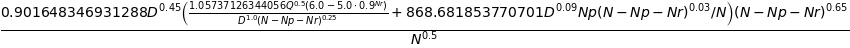

In [5]:
diameter = symbols("D", positive=True)
numExplosive, modules, propellant, rail = symbols('Ne N Np Nr', positive=True)
charge = symbols("Q")

data = FTD.calcDPS({
    "diameter": diameter, 
    "numExplosive": 0,
    "modules": modules,
    "propellant": propellant,
    "speedC": speedC,
    "kineticC": kineticC,
    "armorC": 1,
    "rails": rail,
    "loaders": 1,
    "clipsPerLoader": 3,
    "velCharge": charge
})
dps = data["dps"]
dps

Shell data:

DPS
>{{dps}}

Velocity = {{data}}

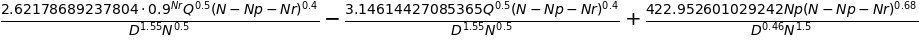

In [6]:
diff(expand(dps), diameter)

According to results, there are some situations when we get negative DPS if we fiddle with railguns

In [7]:
def checkResult(config):
    if config.get("velocity", 0)  < 50:
        return -1.0
    return config["dps"]

## Checking shell modifiers ##

In [8]:
shell_bp = ['apcap', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'bleeder', 'rail', 'rail', 'rail']
FTD.calcSpeedMod(shell_bp)

In [9]:
FTD.calcKineticMod(shell_bp)

# Calculates the best shell for 1 and 2-loaders #
Will output 4 groups of variants

In [10]:
loaderSize = 1
batch = 4
results = FTD.calcBestShells(2, 4, batch, dict(loaders=1, clipsPerLoader=1, velCharge=0), checkResult)
results += FTD.calcBestShells(1, 16, batch, dict(loaders=1, clipsPerLoader=1, velCharge=1000), checkResult)

In [11]:
displayTable(results, ["dps", "damage", "diameter", "velocity", "period", "shell"])

DPS,DAMAGE,DIAMETER,VELOCITY,PERIOD,SHELL
597.36,kinetic=13755:4.5HE=2985:4.5,500,200.56,28.02,"['apcap', 'HE', 'bleeder', 'gunpowder']"
630.93,kinetic=17681:7.7,500,393.90,28.02,"['apcap', 'bleeder', 'gunpowder', 'gunpowder']"
635.08,kinetic=16913:7.1HE=2985:7.1,500,333.32,31.33,"['apcap', 'HE', 'gunpowder', 'gunpowder']"
643.62,kinetic=20166:7.6,500,333.32,31.33,"['apcap', 'solid', 'gunpowder', 'gunpowder']"
1070.67,kinetic=2965:30.0,62,1257.95,2.77,"['apcap', 'solid', 'solid', 'solid', 'solid', 'solid', 'bleeder', 'gunpowder', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail']"
1080.50,kinetic=2992:33.3,62,1396.83,2.77,"['apcap', 'solid', 'solid', 'solid', 'solid', 'bleeder', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail']"
1086.97,kinetic=3010:28.0,62,1175.01,2.77,"['apcap', 'solid', 'solid', 'solid', 'solid', 'solid', 'solid', 'bleeder', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail']"
1091.87,kinetic=3023:30.6,62,1282.86,2.77,"['apcap', 'solid', 'solid', 'solid', 'solid', 'solid', 'bleeder', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail', 'rail']"


What do we see here:

 - Velocity for bleeder is lower than actual: 203 vs 257 for (HE; HE; bleed; gunpowder)
 - Kinetic damage is mostly accurate when velocity is accurate
 - HE damage is accurate
 - Reloading period is accurate
 - AP seems to be accurate when velocity is accurate

According to wiki:
>$AP=0.01av$

Some modules have maximum length, like bleeder.


In [21]:
real_data = {
    ('HE', 'gunpowder'): dict(D=0.5, T=22.16, velocity=326, ap=3.0, exp=2985, kin=2842),
    ('HE', 'HE', 'HE', 'gunpowder'): dict(D=0.5, velocity=169, ap=2.5, exp=6096, kin=6428),
    ('solid', 'solid', 'solid', 'gunpowder'): dict(D=0.5, velocity=219, ap=4.4, kin=16713),
    ('solid', 'solid', 'gunpowder', 'gunpowder'): dict(D=0.5, velocity=219, ap=4.4, kin=17760),
    ('HE', 'HE', 'gunpowder', 'gunpowder'): dict(D=0.5, T=31.33, velocity=333, ap=4.2, exp=4684, kin=7196),
    ('HE', 'HE', 'bleeder', 'gunpowder'): dict(D=0.5, T=28.7, velocity=257, ap=3.5, exp=4684, kin=6399),
    ('HE', 'gunpowder', 'gunpowder', 'gunpowder'): dict(D=0.5, velocity=490, ap=4.6, exp=2985, kin=4263)
}

We need to check whether value 0.01 is for AP is actual. Also we should calculate velocity error.

## Comparing with real results from FTD ##

In [14]:
shell_bp = ['HE', 'HE', 'bleeder', 'gunpowder']
shell = dict(diameter=0.5, velCharge=0, **FTD.calcBulletStats(shell_bp))
FTD.calcCannonData(shell)
shell

{'accuracy': 0.5954583420518296,
 'armorC': 1.3783783783783783,
 'barrel_p': 8.0,
 'damage': {'HE': (4684.060743551104, 2.790367347567821),
  'kinetic': (6170.846882178508, 2.790367347567821)},
 'diameter': 0.5,
 'dps': 346.4385281404378,
 'expMod': 1.0,
 'kineticC': 2.0,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 2,
 'period': 31.332853432887504,
 'propellant': 1,
 'shell': ['HE', 'HE', 'bleeder', 'gunpowder'],
 'shellLength': 1.5,
 'speedC': 1.2,
 'velCharge': 0,
 'velocity': 202.4384154117831,
 'vp': 202.4384154117831}

In [23]:
stats = FTD.calcBulletStats(['solid', 'solid', 'solid', 'gunpowder'])
shell = dict(diameter=0.50, velCharge=0, **stats)
FTD.calcCannonData(shell)
shell

{'accuracy': 0.5954583420518296,
 'armorC': 2.0,
 'barrel_p': 8.0,
 'damage': {'kinetic': (12855.931004538555, 3.373973590196385)},
 'diameter': 0.5,
 'dps': 410.3019545307274,
 'expMod': 1.0,
 'kineticC': 5.0,
 'length': 2.0,
 'modules': 4,
 'period': 31.332853432887504,
 'propellant': 1,
 'shell': ['solid', 'solid', 'solid', 'gunpowder'],
 'shellLength': 1.5,
 'speedC': 1.0,
 'velCharge': 0,
 'velocity': 168.69867950981924,
 'vp': 168.69867950981924}

In [17]:
stats = FTD.calcBulletStats(['HE', 'gunpowder', 'gunpowder', 'gunpowder'])
shell = dict(diameter=0.50, velCharge=0, **stats)
FTD.calcCannonData(shell)
shell

{'accuracy': 0.6655122646461624,
 'armorC': 0.9324324324324325,
 'barrel_p': 24.0,
 'coolers': 3.2481327394196073,
 'damage': {'HE': (2985.0596998510123, 4.566008033338468),
  'kinetic': (4263.429832734652, 4.566008033338468)},
 'diameter': 0.5,
 'dps': 231.33831548765122,
 'expMod': 1.0,
 'kineticC': 1.1666666666666667,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 1,
 'period': 31.332853432887504,
 'propellant': 3,
 'shell': ['HE', 'gunpowder', 'gunpowder', 'gunpowder'],
 'shellLength': 0.5,
 'speedC': 1.0,
 'velCharge': 0,
 'velocity': 489.68781806818356,
 'vp': 489.68781806818356}

In [18]:
FTD.calcKineticMod(['solid', 'solid', 'solid', 'gunpowder'])

In [20]:
stats = FTD.calcBulletStats(['HE', 'HE', 'gunpowder', 'gunpowder'])
shell = dict(diameter=0.50, velCharge=0, **stats)
FTD.calcCannonData(shell)
shell

{'accuracy': 0.628539361054709,
 'armorC': 1.2567567567567568,
 'barrel_p': 16.0,
 'coolers': 0.8167506081120626,
 'damage': {'HE': (4684.060743551104, 4.188998162654085),
  'kinetic': (7155.877591700494, 4.188998162654085)},
 'diameter': 0.5,
 'dps': 377.87615994220926,
 'expMod': 1.0,
 'kineticC': 1.8333333333333333,
 'length': 2.0,
 'modules': 4,
 'numExplosive': 2,
 'period': 31.332853432887504,
 'propellant': 2,
 'shell': ['HE', 'HE', 'gunpowder', 'gunpowder'],
 'shellLength': 1.0,
 'speedC': 1.0,
 'velCharge': 0,
 'velocity': 333.3181333724756,
 'vp': 333.3181333724756}

## This is the test for the shell generator ##

Should iterate every possible shell variant 

In [ ]:
[a for a in FTD.allBodyGen(3)]

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# Testing HE,GP,GP,GP 
values1 = [{"diameter":18, "vel": 363}, {"diameter": 45, "vel": 394}, {"diameter": 83, "vel": 417}, {"diameter":101, "vel": 424}, {"diameter":200, "vel":451}, {"diameter":251, "vel": 460}, {"diameter": 500, "vel":490}]
# Testing HE,HE,GP,GP 
values2 = [{"diameter":18, "vel": 247}, {"diameter": 45, "vel": 268}, {"diameter": 83, "vel": 284}, {"diameter":101, "vel": 289}, {"diameter":200, "vel":307}, {"diameter":251, "vel": 313}, {"diameter": 500, "vel":333}]

"""
vel[0] = Y*diameter[0]**x
...
vel[n] = Y*diameter[n]**x

err[n] = log(n)
"""
def makeFn(modules, props):
    def calcVel(diameter, x, y, z):
        return z*pow(x*diameter,(1+y)) * (props / (modules+props))
    return calcVel

In [ ]:
xdata1 = [a["diameter"] for a in values1]
xdata2 = [a["diameter"] for a in values2]
ydata1 = [a["vel"] for a in values1]
ydata2 = [a["vel"] for a in values2]

In [ ]:
xdata1, xdata2, ydata1, ydata2

In [ ]:
popt1, pcov1 = curve_fit(makeFn(1,3), xdata1, ydata1)
popt2, pcov2 = curve_fit(makeFn(2,2), xdata2, ydata2)

In [ ]:
popt1

In [ ]:
popt2